# LMC Range 1: Psi Computation Notebook

This notebook computes the VGT-based polarization angle map `psi` from a spectral cube.

What it does:
- Loads configuration (`config_path`, `noise_path`) and input FITS cube
- Computes gradients, performs sub-block angle statistics, and derives Stokes-like Q/U
- Aggregates Q/U across velocity, smooths, and converts to `psi`
- Saves `psi` to a FITS file and previews it

Notes:
- Code cells are unchanged functionally; only comments and headings were added
- Keep `config_path` and `noise_path` set correctly before running


## Imports


In [1]:
using PyCall,PyPlot,LsqFit,Images,LinearAlgebra,StatsBase,FFTW,FITSIO,HDF5,Statistics
using LazCore,LazCyvecd,LazInstaller,LazIO,LazType

## Helper functions

Angle statistics, histogram utilities, and gradient-based methods used by VGT.


In [ ]:
using JSON3, Glob, FileIO

In [2]:
function avB2dx(Ax::Mat,Ay::Mat,dn)
	nx,ny=size(Ax)
	Ana=zeros(div(nx,dn),div(ny,dn));
	for  j in 1:div(ny,dn),i in 1:div(nx,dn)
	    is=(i-1)*dn+1;
	    ie=i*dn;
	    js=(j-1)*dn+1;
	    je=j*dn;
	    Axx=Ax[is:ie,js:je];
	    Ayy=Ay[is:ie,js:je];
	    Ana[i,j]=atan.(mean(Ayy[.~isnan.(Ayy)])/mean(Axx[.~isnan.(Ayy)]));
	end
	return Ana
end

avB2dx (generic function with 1 method)

In [3]:
function VGT_QU_mv_error(ppvi::Cube,dn,Ni,Nf,noise)
    nx,ny,nv=size(ppvi);
	Q=zeros(nx,ny,nv);
	U=zeros(nx,ny,nv);
    Qe=zeros(nx,ny,nv);
	Ue=zeros(nx,ny,nv);
	for k in Ni:Nf
        ds=zeros(nx,ny);   
        ds=ppvi[:,:,k];    
        #dsx,dsy=sobel_conv_2d(ds);
        dsx=circshift(ds,(1,0)).-ds
        dsy=circshift(ds,(0,1)).-ds
        dna,dns=sban2d_SNR_mv(dsx,dsy,dn,ds,noise);
        xx=div.(dns,pi);
        for i in 1:size(xx)[1],j in 1:size(xx)[2]
            dns[i,j]-=xx[i,j]*pi;
        end
        for ii in 1:nx,jj in 1:ny
			if(isnan(dna[ii,jj]))
				Q[ii,jj,k]=0;U[ii,jj,k]=0;
                Qe[ii,jj,k]=0;Ue[ii,jj,k]=0;
			else
                Q[ii,jj,k]=ds[ii,jj].*cos.(2.0.*dna[ii,jj]);
				U[ii,jj,k]=ds[ii,jj].*sin.(2.0.*dna[ii,jj]);
                ce=abs(2*sin.(2.0.*dna[ii,jj])*dns[ii,jj])
                se=abs(2*cos.(2.0.*dna[ii,jj])*dns[ii,jj])
                Qe[ii,jj,k]=abs(Q[ii,jj,k])*sqrt((noise/ds[ii,jj])^2+(ce/cos.(2.0.*dna[ii,jj]))^2);
                Ue[ii,jj,k]=abs(U[ii,jj,k])*sqrt((noise/ds[ii,jj])^2+(se/sin.(2.0.*dna[ii,jj]))^2);
			end
        end
        println(string(k)*"/"*string(Nf))
    end
    return Q,U,Qe,Ue
end

VGT_QU_mv_error (generic function with 1 method)

In [4]:
function hist_new(data,range)
    # Linear histogram function
    # Wrapper for the `hist` function for functions written for julia v0.5-
    h=fit(Histogram,data,range)
    ax=h.edges[1];
    ac=h.weights;
    return ax,ac
end

hist_new (generic function with 1 method)

In [5]:
function sban2d_mv(Ax::Mat,Ay::Mat,dn)
	nx,ny=size(Ax)
	Ana=zeros(nx,ny);
	Ans=zeros(nx,ny);
    for  j in dn/2:ny-dn/2,i in dn/2:nx-dn/2
        i=Int(i);
        j=Int(j);
        is=Int(i-dn/2+1);
        ie=Int(i+dn/2);
        js=Int(j-dn/2+1);
        je=Int(j+dn/2);
        try
            Axx=Ax[is:ie,js:je];
            Ayy=Ay[is:ie,js:je];
            binsize=100;
            Apeak,Adisp=fit_gaussian_2d(Axx,Ayy,binsize);
            Ana[Int(i),Int(j)]=Apeak;
            Ans[Int(i),Int(j)]=Adisp;
        catch
            Ana[Int(i),Int(j)]=NaN;
            Ans[Int(i),Int(j)]=NaN;
        end
        #println("j="*string(j)*";i="*string(i))
    end
    Ana[1:Int(dn/2-1),:].=NaN;
    Ana[:,1:Int(dn/2-1)].=NaN;
    Ana[Int(nx-dn/2+1):nx,:].=NaN;
    Ana[:,Int(ny-dn/2+1):ny].=NaN;
    Ans[isnan.(Ana)].=NaN; 
	return Ana,Ans
end

sban2d_mv (generic function with 1 method)

In [6]:
function getmap(ppv::Cube,vz,peak)
    nx,ny,nv=size(ppv);
	I=zeros(nx,ny);
	C=zeros(nx,ny);
	Ch=zeros(nx,ny);
	for i in 1:nx,j in 1:ny,k in 1:nv
        I[i,j]+=ppv[i,j,k]
        C[i,j]+=ppv[i,j,k]*vz[k]
	end
	C=C./I;
    C[C.>maximum(vz)].=NaN
    C[C.< minimum(vz)].=NaN;
    dC=std(C[.~isnan.(C)]);
	for i in 1:nx,j in 1:ny,k in 1:nv
        vchp=vz[peak];
        vch=vz[k];
     if (abs(vch-vchp)<0.5*dC)
        Ch[i,j]+=ppv[i,j,k]
	 end
	end
    return I,C,Ch
end

getmap (generic function with 1 method)

In [7]:
function getcoor(header,nx,ny,nv)
    CRPIX1=header["CRPIX1"];
    CRVAL1=header["CRVAL1"];
    CDELT1=header["CDELT1"];
    CRPIX2=header["CRPIX2"];
    CRVAL2=header["CRVAL2"];
    CDELT2=header["CDELT2"];
    CRPIX3=header["CRPIX3"];
    CRVAL3=header["CRVAL3"];
    CDELT3=header["CDELT3"];
    RA=zeros(nx);
    DEC=zeros(ny);
    vz=zeros(nv);
    for i in 1:nx
        RA[i]=CRVAL1+(i-CRPIX1)*CDELT1
    end
    for j in 1:ny
        DEC[j]=CRVAL2+(j-CRPIX2)*CDELT2
    end
    for k in 1:nv
        vz[k]=CRVAL3+(k-CRPIX3)*CDELT3
    end
    xi=CRVAL1+(0-CRPIX1)*CDELT1;
    xe=CRVAL1+(nx-CRPIX1)*CDELT1;
    yi=CRVAL2+(0-CRPIX2)*CDELT2;
    ye=CRVAL2+(ny-CRPIX2)*CDELT2;
    print("xi=",xi,";xe=",xe,";yi=",yi,";ye=",ye)
    return RA,DEC,vz
end

getcoor (generic function with 1 method)

In [8]:
function getpeak(d::Cube)
    nx,ny,nv=size(d);
    peak=zeros(nv);
    for k in 1:nv, j in 1:ny, i in 1:nx
      if(~isnan(d[i,j,k]))
       peak[k]+=d[i,j,k]
      end
    end
    return peak
end

getpeak (generic function with 1 method)

In [9]:
function imfilter_gaussian(d::Mat,p::Number)
    im=imfilter(d,Kernel.gaussian(p),NA())
    return im
end

imfilter_gaussian (generic function with 1 method)

In [10]:
function de_resolution(b::Mat,dn)
    nx,ny=size(b)
    bx=zeros(div(nx,dn),div(ny,dn));
   for i in 1:div(nx,dn),j in 1:div(ny,dn)
        a=b[i*dn-dn+1:i*dn,j*dn-dn+1:j*dn]
        bx[i,j]=mean(a)
   end
    return bx
end

de_resolution (generic function with 1 method)

In [11]:
# """@internal"""
function maxid(ax::Vec)
	return findall(ax.==maximum(ax));
end

maxid (generic function with 1 method)

In [12]:
   # """@internal"""
function maxid(ax::Mat)
	return findall(ax.==maximum(ax));
end

maxid (generic function with 2 methods)

In [13]:
function fit_gaussian_2dx(Ax,Ay,binsize)
	# KH : The subblock Gaussian fitting algorithm
	#      this algorithm was ignoring the periodicity of the angle
	#      and use the Real space defined Gaussian to fit instead.
	#      a fftshift is required to play for the two cases.
	phi=atan.(Ay./Ax);
	phix=phi[.~isnan.(phi)];
	Gauss(x,p)=p[1]*exp.(.-(x.-p[2]).^2 .*p[3]);
	Gauss_x(x,p)=p[1]*exp.(.-(x.-p[2]).^2 .*p[3]).+p[4];
	ax,ac=hist_new(phi[:],linspace(-pi/2,pi/2,binsize+1))
	ax=.5*(ax[1:end-1]+ax[2:end]);
	if (abs.(ax[maxid(ac)])[1]<pi/4)
		y=ac./sum(ac);
		y[isnan.(y)].=0;
		try
			fit1=curve_fit(Gauss_x,ax,y,[maximum(y),0.0,1.0,0])
			if(maximum(y).==0)
				sigma=NaN;
				return fit1.param[2],sigma;
			else
				sigma=margin_error(fit1,0.05);
				return fit1.param[2],sigma[2];
			end
		catch
			fit1=curve_fit(Gauss,ax,y,[maximum(y),0.0,1.0])
			if(maximum(y).==0)
				sigma=NaN;
				return fit1.param[2],sigma;
			else
				sigma=margin_error(fit1,0.05);
				return fit1.param[2],sigma[2];
			end
		end
	else
		ax=ax.-pi./2;
		ac=fftshift(ac);
		y=ac./sum(ac);
		y[isnan.(y)].=0;
		try
			fit1=curve_fit(Gauss_x,ax,y,[maximum(y),-pi/2,1.0,0]);
			if(maximum(y).==0)
				sigma=NaN;
				return fit1.param[2],sigma;
			else
				sigma=margin_error(fit1,0.05);
				return fit1.param[2],sigma[2];
			end
		catch 
			fit1=curve_fit(Gauss,ax,y,[maximum(y),-pi/2,1.0]);
			if(maximum(y).==0)
				sigma=NaN;
				return fit1.param[2],sigma;
			else
				sigma=margin_error(fit1,0.05);
				return fit1.param[2],sigma[2];
			end
		end
	end
end

fit_gaussian_2dx (generic function with 1 method)

In [14]:
function sban2d_SNR(Ax::Mat,Ay::Mat,dn,Ch::Mat,noise)
	nx,ny=size(Ax)
	Ana=zeros(div(nx,dn),div(ny,dn));
	Ans=zeros(div(nx,dn),div(ny,dn));
	Ax[Ch.<3*noise].=NaN;
	Ay[Ch.<3*noise].=NaN;
	for  j in 1:div(ny,dn),i in 1:div(nx,dn)
	   	is=(i-1)*dn+1;
	   	ie=i*dn;
	   	js=(j-1)*dn+1;
	   	je=j*dn;
	   	Axx=Ax[is:ie,js:je];
	   	Ayy=Ay[is:ie,js:je];
	   	Axx=Axx[.~isnan.(Axx)];
	   	Ayy=Ayy[.~isnan.(Ayy)];
	   	if(length(Axx)>100) #CHANGED FROM 100 to 200
			binsize=100;
			Apeak,Adisp=fit_gaussian_2dx(Axx,Ayy,binsize);
			Ana[i,j]=Apeak;
			Ans[i,j]=Adisp;
		else
			Ana[i,j]=NaN;
			Ans[i,j]=NaN;
	   #println("j="*string(j)*";i="*string(i))
		end
	end
	return Ana,Ans
end

sban2d_SNR (generic function with 1 method)

In [15]:
function sban2d_SNR_mv(Ax::Mat,Ay::Mat,dn,Ch::Mat,noise)
	nx,ny=size(Ax)
	Ana=zeros(nx,ny);
	Ans=zeros(nx,ny);
    Ax[Ch.<3*noise].=NaN;
	Ay[Ch.<3*noise].=NaN;
    for  j in dn/2:ny-dn/2,i in dn/2:nx-dn/2
        i=Int(i);
        j=Int(j);
        is=Int(i-dn/2+1);
        ie=Int(i+dn/2);
        js=Int(j-dn/2+1);
        je=Int(j+dn/2);
        try
            Axx=Ax[is:ie,js:je];
            Ayy=Ay[is:ie,js:je];
            Axx=Axx[.~isnan.(Axx)];
            Ayy=Ayy[.~isnan.(Ayy)];
            if(length(Axx)>100) #CHANGED FROM 100  to dn*dn*0.95
                #println("threhold = "*string(dn*dn*0.3) ) 
                binsize=100;
                Apeak,Adisp=fit_gaussian_2dx(Axx,Ayy,binsize);
                Ana[Int(i),Int(j)]=Apeak;
                Ans[Int(i),Int(j)]=Adisp;
            else
                Ana[Int(i),Int(j)]=NaN;
                Ans[Int(i),Int(j)]=NaN;
            #println("j="*string(j)*";i="*string(i))
            end
        catch
            Ana[Int(i),Int(j)]=NaN;
            Ans[Int(i),Int(j)]=NaN;
        end
        #println("j="*string(j)*";i="*string(i))
    end
    Ana[1:Int(dn/2-1),:].=NaN;
    Ana[:,1:Int(dn/2-1)].=NaN;
    Ana[Int(nx-dn/2+1):nx,:].=NaN;
    Ana[:,Int(ny-dn/2+1):ny].=NaN;
    Ans[isnan.(Ana)].=NaN;
	return Ana,Ans
end

sban2d_SNR_mv (generic function with 1 method)

## Configuration and data loading

Reads JSON config (`config_path`, `noise_path`), locates FITS cube, and loads data.


In [16]:
function VGT_QU(ppvi::Cube,dn,Ni,Nf,noise)
    nx,ny,nv=size(ppvi);
	nxx,nyy=div(nx,dn),div(ny,dn);
	Q=zeros(nxx,nyy,nv);
	U=zeros(nxx,nyy,nv);
	Q2d=zeros(nxx,nyy);
	U2d=zeros(nxx,nyy);
	for k in Ni:Nf
        ds=zeros(nx,ny);   
        ds=ppvi[:,:,k];    
        #dsx,dsy=sobel_conv_2d(ds);
        dsx=circshift(ds,(1,0)).-ds
        dsy=circshift(ds,(0,1)).-ds
        dna,dns=sban2d_SNR(dsx,dsy,dn,ds,noise);
        Ia=de_resolution(ppvi[:,:,k],dn); 
        for ii in 1:div(nx,dn),jj in 1:div(ny,dn)
			if(isnan(dna[ii,jj]))
				Q[ii,jj,k]=0;
				U[ii,jj,k]=0;
			else
				Q[ii,jj,k]=Ia[ii,jj].*cos.(2 .*dna[ii,jj]);
				U[ii,jj,k]=Ia[ii,jj].*sin.(2 .*dna[ii,jj]);
			end
        end
        Q2d.+=Q[:,:,k];
        U2d.+=U[:,:,k];
    end
    return Q2d,U2d
end

VGT_QU (generic function with 1 method)

In [17]:
function VGT_QU_mv(ppvi::Cube,dn,Ni,Nf,noise)
    nx,ny,nv=size(ppvi);
	Q=zeros(nx,ny,nv);
	U=zeros(nx,ny,nv);
	Q2d=zeros(nx,ny);
	U2d=zeros(nx,ny);
	for k in Ni:Nf
		println(k)
        ds=zeros(nx,ny);   
        ds=ppvi[:,:,k];    
        #dsx,dsy=sobel_conv_2d(ds);
        dsx=circshift(ds,(1,0)).-ds
        dsy=circshift(ds,(0,1)).-ds
        dna,dns=sban2d_SNR_mv(dsx,dsy,dn,ds,noise);
        #Ia=de_resolution(ppvi[:,:,k],dn); 
        for ii in 1:nx,jj in 1:ny
			if(isnan(dna[ii,jj]))
				Q[ii,jj,k]=0;
				U[ii,jj,k]=0;
			else
				Q[ii,jj,k]=ds[ii,jj].*cos.(2.0.*dna[ii,jj]);
				U[ii,jj,k]=ds[ii,jj].*sin.(2.0.*dna[ii,jj]);
			end
        end
        Q2d.+=Q[:,:,k];
        U2d.+=U[:,:,k];
    end
    return Q2d,U2d
end

VGT_QU_mv (generic function with 1 method)

In [18]:
function linspace(a,b,c)
	# KH: a Lower limit, B Upper limit, C number of points
	# KH : Construct a 1d linspace
	width =(b-a)/c;
	x=zeros(c);
	xx=a:width:b
	for i in 1:c
        x[i]=xx[i]
	end
	return x
end

linspace (generic function with 1 method)

In [ ]:
# config_path = "config/M06BH23_HC0.json";  # update path when running
cfg = JSON3.read(open(config_path, "r"));

programID = String(cfg["programID"]);
folder_path = joinpath("data", programID);
pattern = String(cfg["fits_file"]);
subblock_size = Int(cfg["subblock_size"]);
noise_multiplier = Int(cfg["noise_multiplier"]);
noise_mult= string(noise_multiplier)

cube_path = glob(pattern, folder_path)[1];
# fnoise = FITS(cube_path);
f = FITS(cube_path);
dn = subblock_size;

In [ ]:
cfg_noise = JSON3.read(open(noise_path, "r"));
noise = Float64(cfg_noise["Pixel mean"]) * noise_multiplier;

In [19]:
# fnoise = FITS("/Users/macbook/Desktop/ngc7538/data/M06BH23_HC0/jcmth20061221_00024_01_reduced001_nit_000.fits");
# d2d_noise=read(fnoise[1]);
# nxn,nyn,nvn=size(d2d_noise);
# dnoise=zeros(nxn,nyn);
# dnoise=d2d_noise[:,:,1];
# noise2=std(dnoise[:,:][.~isnan.(dnoise[:,:])]);
# println(noise2);

1.1098187


In [20]:
# println(size(d2d_noise));

(97, 98, 1876)


In [21]:
# println(d2d_noise[:,:,:,1]);

## Main processing

- Compute coordinates and velocity channel indices
- Run VGT to derive Q/U with error estimates
- Persist noise snapshot for reproducibility


In [ ]:
d2d=read(f[1]);
nx,ny,nv=size(d2d);
d=zeros(nx,ny,nv);
d=d2d[:,:,:,1];

## Q/U projection, smoothing, and psi

- Project Q/U cubes to 2D
- Apply Gaussian smoothing
- Mask invalid intensities
- Compute psi and preview


In [ ]:
println(noise);

## Save outputs

Writes `psi` to a FITS file inside the program data folder.


In [ ]:
header=read_header(f[1]);

In [ ]:
RA,DEC,vz=getcoor(header,nx,ny,nv);
dv=(vz[2]-vz[1]);
#noise=std(d[:,:,1][.~isnan.(d[:,:,1])]);
println(noise);

In [22]:
#assign the 3D PPV cube to d;

# dn=40;#sub-block size
Ni=Int(round(abs((vz[1]-vz[1])/dv)))+1; #inital velocity
Nf=Int(round(abs((vz[end]-vz[1])/dv)))+1; #end velocity
#println(Nf)
Qi, Ui, Qie, Uie=VGT_QU_mv_error(d,dn,Ni,Nf,noise);

xi=348.5212583333334;xe=348.3595916666667;yi=61.383193888888904;ye=61.546527222222231.1098187
1/1876
2/1876
3/1876
4/1876
5/1876
6/1876
7/1876
8/1876
9/1876
10/1876
11/1876
12/1876
13/1876
14/1876
15/1876
16/1876
17/1876
18/1876
19/1876
20/1876
21/1876
22/1876
23/1876
24/1876
25/1876
26/1876
27/1876
28/1876
29/1876
30/1876
31/1876
32/1876
33/1876
34/1876
35/1876
36/1876
37/1876
38/1876
39/1876
40/1876
41/1876
42/1876
43/1876
44/1876
45/1876
46/1876
47/1876
48/1876
49/1876
50/1876
51/1876
52/1876
53/1876
54/1876
55/1876
56/1876
57/1876
58/1876
59/1876
60/1876
61/1876
62/1876
63/1876
64/1876
65/1876
66/1876
67/1876
68/1876
69/1876
70/1876
71/1876
72/1876
73/1876
74/1876
75/1876
76/1876
77/1876
78/1876
79/1876
80/1876
81/1876
82/1876
83/1876
84/1876
85/1876
86/1876
87/1876
88/1876
89/1876
90/1876
91/1876
92/1876
93/1876
94/1876
95/1876
96/1876
97/1876
98/1876
99/1876
100/1876
101/1876
102/1876
103/1876
104/1876
105/1876
106/1876
107/1876
108/1876
109/1876
110/1876
111/1876
112/1876
113/18

In [ ]:
open(joinpath(folder_path, string("noise",noise_mult,"x.txt")), "w") do io
    write(io, string(noise))
end

In [23]:
Qa=Proj(Qi,3);#project the Q cube into Q map 
Ua=Proj(Ui,3);#project the Q cube into Q map 
Qa[Qa.==0].=NaN;
Ua[Ua.==0].=NaN; 

ker = 4;
Qb=imfilter_gaussian(Qa,ker); 
Ub=imfilter_gaussian(Ua,ker);
Ii = sum(d2d;dims=3)[:,:,1]
Qb[isnan.(Ii)].=NaN;
Ub[isnan.(Ii)].=NaN;
psi=0.5.*atan.(Ub,Qb);
psi.+=3pi/2;

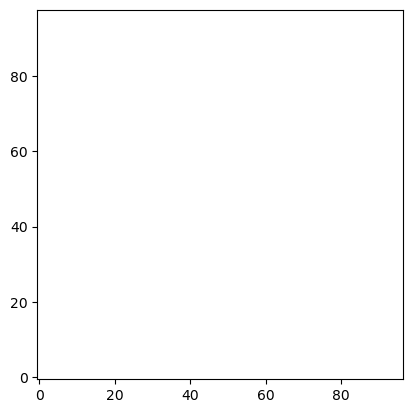

PyObject <matplotlib.image.AxesImage object at 0x16be0dcf0>

In [24]:
imshow(psi',origin="lower",cmap="jet")

In [25]:
psi_path = joinpath(folder_path, string("psi",noise_mult,"x.fits"))
f = FITS(psi_path, "w")
write(f, psi)
close(f)
println("Saved psi to: ", psi_path)